In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split

import tensorflow
tensorflow.random.set_seed(1234)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from sklearn.metrics import mean_absolute_error

from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import statsmodels.api as sm

In [2]:
#cluster_candidates = pd.read_csv('/Users/steven/Documents/CPoint/data/pleiades_candidates.csv')
cluster_candidates = pd.read_csv('../PleiadesTidalTails/data/clean.csv')
scaler_astrometry = StandardScaler()
scaler_rv = StandardScaler()

cluster_candidates[['ra','dec','pmra','pmdec','parallax']] = scaler_astrometry.fit_transform(cluster_candidates[['ra','dec','pmra','pmdec','parallax']])
cluster_candidates[['radial_velocity']] = scaler_rv.fit_transform(cluster_candidates[['radial_velocity']])

del cluster_candidates['Unnamed: 0']

# for i in range(len(cluster_candidates)):
#         #if (np.median(cluster_candidates['ra']) > 300.) or (np.median(cluster_candidates['ra']) < 10.):
#         if cluster_candidates['ra'].values[i] > 300.:
#                 cluster_candidates['ra'].values[i] -= 360
#                 #cluster_candidates.loc[cluster_candidates['ra'] > 300, 'ra'] -= 360

print(len(cluster_candidates))

cluster_candidates_rv = cluster_candidates[~cluster_candidates['radial_velocity'].isna()]
cluster_candidates_rv = cluster_candidates_rv[~cluster_candidates_rv['radial_velocity_error'].isna()]
print(len(cluster_candidates_rv))
cluster_candidates_rv = cluster_candidates_rv[(np.abs(cluster_candidates_rv['radial_velocity']) <= 0.3*np.std(cluster_candidates_rv['radial_velocity']))]
cluster_candidates_rv.info()

1502
509
<class 'pandas.core.frame.DataFrame'>
Index: 401 entries, 0 to 1488
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   level_0                     401 non-null    int64  
 1   index                       401 non-null    int64  
 2   source_id                   401 non-null    int64  
 3   ra                          401 non-null    float64
 4   ra_error                    401 non-null    float64
 5   dec                         401 non-null    float64
 6   dec_error                   401 non-null    float64
 7   l                           401 non-null    float64
 8   b                           401 non-null    float64
 9   parallax                    401 non-null    float64
 10  parallax_error              401 non-null    float64
 11  pmra                        401 non-null    float64
 12  pmra_error                  401 non-null    float64
 13  pmdec                       40

In [17]:
# cluster_candidates_rv[['radial_velocity','radial_velocity_error','ra','dec','pmra','pmdec','parallax']] = \
#     StandardScaler().fit_transform(cluster_candidates_rv[['radial_velocity','radial_velocity_error','ra','dec','pmra','pmdec','parallax']])

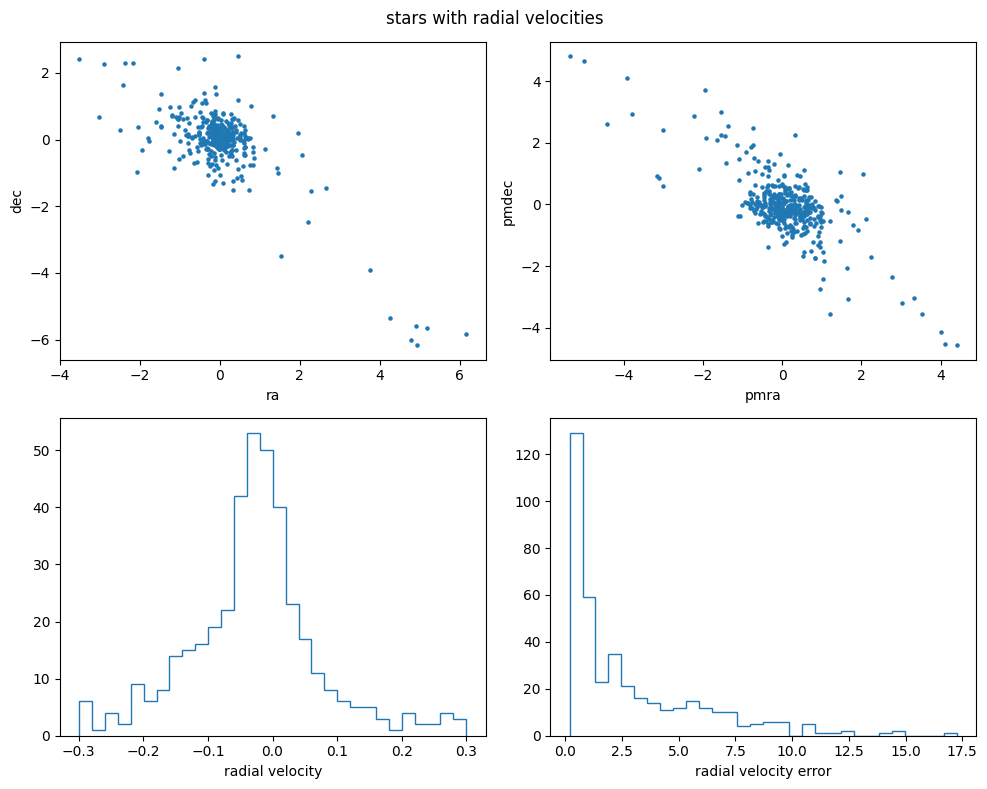

In [3]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

fig.suptitle('stars with radial velocities')

ax[0,0].scatter(cluster_candidates_rv['ra'], cluster_candidates_rv['dec'], s=5)
ax[0,0].set_xlabel('ra')
ax[0,0].set_ylabel('dec')

ax[0,1].scatter(cluster_candidates_rv['pmra'], cluster_candidates_rv['pmdec'], s=5)
ax[0,1].set_xlabel('pmra')
ax[0,1].set_ylabel('pmdec')

ax[1,0].hist(cluster_candidates_rv['radial_velocity'], bins=30, density=False, histtype='step')
ax[1,0].set_xlabel('radial velocity')

ax[1,1].hist(cluster_candidates_rv['radial_velocity_error'], bins=30, histtype='step', density=False)
ax[1,1].set_xlabel('radial velocity error')
fig.tight_layout()
plt.show()

In [4]:
len(cluster_candidates), len(cluster_candidates_rv)

(1502, 401)

In [ ]:
#y_train = np.vstack([y_train, weights_train]).T
#y_val = np.vstack([y_val, weights_val]).T

In [65]:
x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec','parallax']])
#x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec']])
#x_data = np.array(cluster_candidates_rv[['l','b','pmra','pmdec','parallax']])

#y_data = np.array(cluster_candidates_rv[['radial_velocity','radial_velocity_error']])
y_data = np.array(cluster_candidates_rv[['radial_velocity']])
x_data.shape, y_data.shape

((401, 5), (401, 1))

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=42)

# normalizer = Normalizer()
# x_train = normalizer.fit_transform(x_train)
# x_test = normalizer.fit_transform(x_test)
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

print('Training shape:', x_train.shape, y_train.shape)
print('Testing shape:', x_test.shape, y_test.shape)

Training shape: (240, 5) (240, 1)
Testing shape: (161, 5) (161, 1)


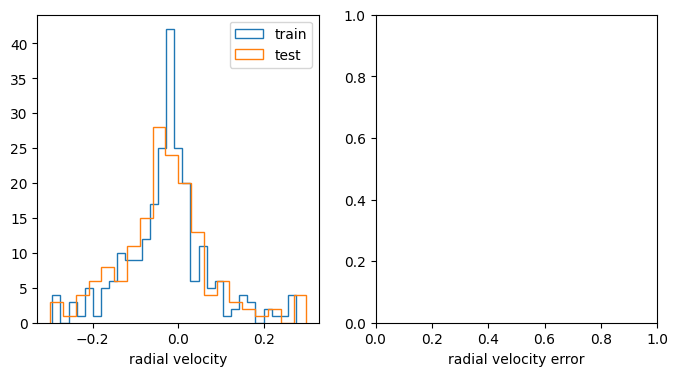

In [67]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(y_train[:,0], bins=30, density=False, histtype='step', label='train')
plt.hist(y_test[:,0], bins=20, density=False, histtype='step', label='test')
plt.legend()
plt.xlabel('radial velocity')

plt.subplot(1,2,2)
# plt.hist(y_train[:,1], bins=30, density=False, histtype='step', label='train')
# plt.hist(y_test[:,1], bins=20, density=False, histtype='step', label='test')
# plt.legend()
plt.xlabel('radial velocity error')
plt.show()

# SVM

In [ ]:
# svr_lin = SVR(kernel = 'linear')
# svr_rbf = SVR(kernel = 'rbf')
# svr_poly = SVR(kernel = 'poly')

# svr_lin.fit(x_train, y_train)
# svr_rbf.fit(x_train, y_train)
# svr_poly.fit(x_train, y_train)

# fig, axes = plt.subplots(1,2, figsize=(8,4))
# axes[0].scatter(x=y_train, y=svr_lin.predict(x_train), s=5)
# axes[0].scatter(x=y_train, y=svr_rbf.predict(x_train), s=5)
# axes[0].scatter(x=y_train, y=svr_poly.predict(x_train), s=5)
# axes[0].set_xlabel("Actual", fontsize=10)
# axes[0].set_ylabel("Predicted",  fontsize=10)
# axes[0].set_title("Training")
# x = np.linspace(*axes[0].get_xlim())
# axes[0].plot(x, x, color='red', ls='--', lw=0.5)

# axes[1].scatter(x=y_test, y=svr_lin.predict(x_test), s=5)
# axes[1].scatter(x=y_test, y=svr_rbf.predict(x_test), s=5)
# axes[1].scatter(x=y_test, y=svr_poly.predict(x_test), s=5)
# axes[1].set_xlabel("Actual", fontsize=10)
# axes[1].set_ylabel("Predicted",  fontsize=10)
# axes[1].set_title("Validation")
# x = np.linspace(*axes[1].get_xlim())
# axes[1].plot(x, x, color='red', ls='--', lw=0.5)
# fig.tight_layout()
# plt.show()

# Gaussian regression

In [ ]:
# kernel = DotProduct() + WhiteKernel()
# gpr = GaussianProcessRegressor(kernel=kernel, random_state=1234).fit(x_train, y_train)
# print(gpr.score(x_train, y_train))

# fig, axes = plt.subplots(1,2, figsize=(8,4))
# axes[0].scatter(x=y_train, y=gpr.predict(x_train), s=5)
# axes[0].set_xlabel("Actual", fontsize=10)
# axes[0].set_ylabel("Predicted",  fontsize=10)
# axes[0].set_title("Training")
# x = np.linspace(*axes[0].get_xlim())
# axes[0].plot(x, x, color='red', ls='--', lw=0.5)

# axes[1].scatter(x=y_test, y=gpr.predict(x_test), s=5)
# axes[1].set_xlabel("Actual", fontsize=10)
# axes[1].set_ylabel("Predicted",  fontsize=10)
# axes[1].set_title("Validation")
# x = np.linspace(*axes[1].get_xlim())
# axes[1].plot(x, x, color='red', ls='--', lw=0.5)
# fig.tight_layout()
# plt.show()

# non-parametric regression

In [7]:
from sklearn.kernel_ridge import KernelRidge

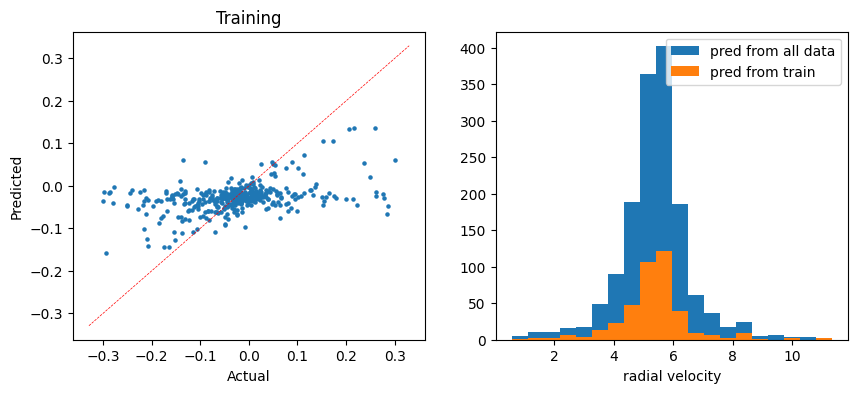

In [68]:
#smoothed = sm.nonparametric.lowess(exog=x_data, endog=y_data, frac=0.15, is_sorted=False)
# 'cosine', 'linear', 'poly', 'chi2', 'additive_chi2', 'rbf', 'laplacian', 'sigmoid', 'polynomial', 'precomputed'
clf = KernelRidge(kernel='rbf', gamma=0.05, alpha=1.0)
clf.fit(x_data, y_data)
x_full = np.array(cluster_candidates[['ra','dec','pmra','pmdec','parallax']])
y_pred = clf.predict(x_full)
y_pred_train = clf.predict(x_data)


fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(y_data, y_pred_train, s=5)
ax[0].set_xlabel("Actual", fontsize=10)
ax[0].set_ylabel("Predicted",  fontsize=10)
ax[0].set_title("Training")
x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x, x, color='red', ls='--', lw=0.5)

#ax[1].hist(scaler_rv.inverse_transform(y_pred), bins=20)
ax[1].hist(scaler_rv.inverse_transform(y_pred), bins=20, label='pred from all data')
ax[1].hist(scaler_rv.inverse_transform(y_pred_train), bins=20, label='pred from train')
ax[1].set_xlabel("radial velocity", fontsize=10)
ax[1].legend()
fig.show()

# Neural Network

In [55]:
from functools import partial

In [108]:
tensorflow.keras.backend.clear_session()

In [111]:
# # build the model!
# model = Sequential()
# model.add(Dense(1000, input_shape=(x_train.shape[1],), activation='relu')) # (features,)
# model.add(Dropout(0.2))
# model.add(Dense(500, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(250, activation='relu'))
# model.add(Dense(1, activation='linear')) # output node
# model.summary() # see what your model looks like

#initializer = tensorflow.keras.initializers.glorot_uniform(seed=1)
#kernel_initializer=initializer

# model = Sequential([
#     Input(shape=(x_train.shape[1],)),
#     Dense(30, activation='relu'),
#     Dense(30, activation='relu'),
#     #BatchNormalization(),
#     Dense(30, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.L2(0.001)),
#     Dropout(0.3),
#     Dense(30, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.L2(0.001)),
#     #BatchNormalization(),
#     Dense(30, activation='relu'),
#     Dense(1, activation='linear')
# ])
alpha_relu = 0.01

model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(30, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
    Dense(30, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
    Dense(100, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
    Dropout(0.3),
    Dense(100, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
    Dense(30, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
    Dense(30, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
    Dense(1, activation='linear')
])

# model = Sequential([
#     Input(shape=(x_train.shape[1],)),
#     Dense(50, activation='relu'),
#     Dropout(0.2),
#     Dense(100, activation='relu'),
#     Dropout(0.2),
#     Dense(100, activation='relu'),
#     Dropout(0.2),
#     Dense(50, activation='relu'),
#     Dense(1, activation='linear')
# ])
# partial(tensorflow.nn.leaky_relu, alpha=0.01)
# model = Sequential([
#     Input(shape=(x_train.shape[1],)),
#     Dense(500, activation='tanh', kernel_initializer=initializer),
#     Dense(250, activation='tanh'),
#     Dropout(0.2),
#     Dense(125, activation='tanh'),
#     Dropout(0.2),
#     Dense(50, activation='tanh'),
#     Dense(1, activation='linear')
# ])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 30)                │        180 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 30)                │        930 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 100)               │      3,100 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 100)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 100)               │     10,100 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 30)                │      3,030 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 30)                │        930 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 1)                 │         31 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 18,301 (71.49 KB)

 Trainable params: 18,301 (71.49 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# def LikelihoodLossFunction(y_true, y_pred):
#     # shape of y_pred should be (nsamples, 2)
#     # the first column should be the line-of-sight velocity
#     # the second column is the uncertainty
#     SIGMA = K.abs(y_pred[:, 1]) + 1e-6
#     LOC = y_pred[:, 0]
#     X = y_true[:, 0]
#     weights = y_true[:,1]
#     ARG = K.pow((X - LOC),2) / (2 * K.pow(SIGMA,2))
#     PREFACT = K.log(K.pow(2 * np.pi * K.pow(SIGMA,2), -0.5))
#     return K.mean((ARG - PREFACT) * weights)

# def custom_loss_(y_true, y_pred):
#     return tensorflow.reduce_mean(tensorflow.square(y_true - y_pred))

def custom_loss(y_true, y_pred):
    v_los =  y_true[:,0]
    sigma_los = y_true[:,1]
    v_los_pred = y_pred[:,0]
    ARG = tensorflow.pow((v_los - v_los_pred), 2) / (2 * tensorflow.pow(sigma_los, 2))
    PREFACT = tensorflow.math.log(tensorflow.pow(2 * np.pi * tensorflow.pow(sigma_los, 2), -0.5))
    return tensorflow.reduce_mean(ARG - PREFACT)

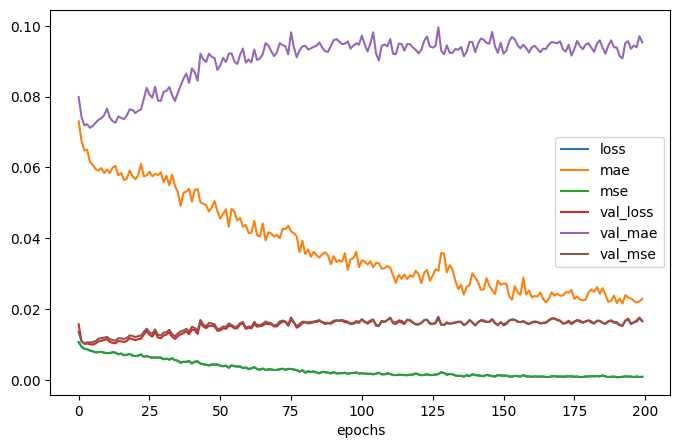

In [112]:
#metrics = ['mean_squared_error', tensorflow.keras.losses.MAE, tensorflow.keras.metrics.R2Score()]
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mae','mse'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=tensorflow.keras.losses.MeanSquaredError(), metrics=['mae','mse'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=custom_loss, metrics=['mse'])
model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=tensorflow.keras.losses.MeanSquaredError(), metrics=['mse','mae'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=tensorflow.keras.losses.MeanSquaredLogarithmicError(), metrics=['mse','mae'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=tensorflow.keras.losses.MeanAbsolutePercentageError(), metrics=['mse','mae'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=tensorflow.keras.losses.MeanAbsoluteError(), metrics=['mse','mae'])
history = model.fit(x_train, y_train, epochs=200, batch_size=30, validation_data=(x_test, y_test), verbose=0)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel('epochs')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


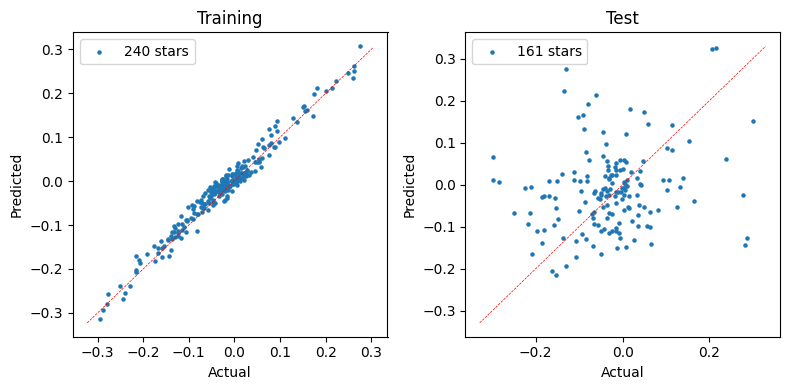

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
Train: 0.01548547396626662
Test: 0.09531920140872621


In [113]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].scatter(y_train[:,0], model.predict(x_train).flatten(), s=5, label='%s stars'%len(y_train[:,0]))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)
axes[0].legend()

axes[1].scatter(y_test[:,0], model.predict(x_test).flatten(), s=5, label='%s stars'%len(y_test[:,0]))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red', ls='--', lw=0.5)
axes[1].legend()

fig.tight_layout()
plt.show()

pred = model.predict(x_test)
trainpreds = model.predict(x_train)

print('Train:',mean_absolute_error(y_train[:,0], trainpreds)) # train
print('Test:',mean_absolute_error(y_test[:,0], pred)) # test

In [ ]:
# cluster_candidates[['radial_velocity','radial_velocity_error','ra','dec','pmra','pmdec','parallax']] = \
#     scaler.inverse_transform(cluster_candidates[['radial_velocity','radial_velocity_error','ra','dec','pmra','pmdec','parallax']])

# Predict on all data

(1502, 5)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


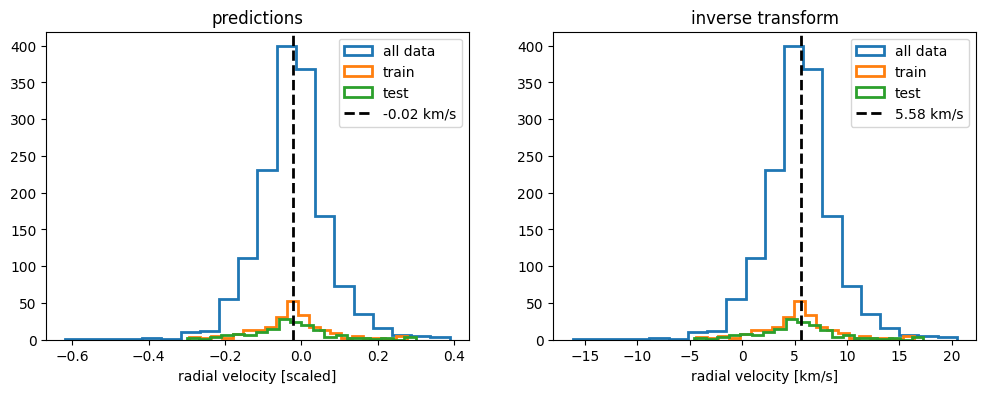

In [114]:
x_all = np.array(cluster_candidates[['ra','dec','pmra','pmdec','parallax']])
print(x_all.shape)
y_pred_all = model.predict(x_all).flatten()
v_mean_all = np.median(y_pred_all)

cluster_candidates['vel_pred'] = y_pred_all

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].set_title('predictions')
ax[0].hist(cluster_candidates['vel_pred'], bins=20, label='all data', histtype='step', lw=2)
ax[0].hist(y_train[:,0], bins=20, label='train', histtype='step', lw=2)
ax[0].hist(y_test[:,0], bins=20, label='test', histtype='step', lw=2)
ax[0].axvline(v_mean_all, label='{:.2f} km/s'.format(v_mean_all), lw=2, ls='dashed', c='k')
ax[0].legend()
ax[0].set_xlabel('radial velocity [scaled]')

ax[1].set_title('inverse transform')
ax[1].hist(scaler_rv.inverse_transform(cluster_candidates['vel_pred'].values.reshape(-1, 1)), bins=20, label='all data', histtype='step', lw=2)
ax[1].hist(scaler_rv.inverse_transform(y_train[:,0].reshape(-1, 1)), bins=20, label='train', histtype='step', lw=2)
ax[1].hist(scaler_rv.inverse_transform(y_test[:,0].reshape(-1, 1)), bins=20, label='test', histtype='step', lw=2)
vel_med_predicted = np.median(scaler_rv.inverse_transform(cluster_candidates['vel_pred'].values.reshape(-1, 1)))
ax[1].axvline(vel_med_predicted, label='{:.2f} km/s'.format(vel_med_predicted), lw=2, ls='dashed', c='k')
ax[1].legend()
ax[1].set_xlabel('radial velocity [km/s]')
plt.show()